In [1]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Permute,  Reshape,  Lambda, Concatenate
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers import merge, Multiply

K.set_image_dim_ordering("th")
SINGLE_ATTENTION_VECTOR = False


def attention_3d_block(inputs,timesteps):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    time_steps=timesteps
    print(inputs.shape)
    print(input_dim)
    print(time_steps)
    #a_probs = Conv1D(input_dim,3,strides=1,padding='same',activation='softmax')(inputs)
    #neurVec=[]
    #for x in range(0,100):
    #    filterImg=Lambda(lambda element : element[:,x,:,:])(a)
    #    flatImg = Flatten()(filterImg)
    #    output = Dense(1, activation='sigmoid')(flatImg)
    #    neurVec.append(output)
    
    
    
    
    #a = Permute((2, 1))(inputs)
    a_probs = Conv1D(input_dim,3,strides=1,padding='same',activation='softmax')(inputs)
    #a = Reshape((-1,input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
    #a = Conv2D(100,3,padding='same')(a)
    #neurVec=[]
    #for x in range(0,100):
    #    filterImg=Lambda(lambda element : element[:,x,:,:])(a)
    #    flatImg = Flatten()(filterImg)
    #    output = Dense(1, activation='sigmoid')(flatImg)
    #    neurVec.append(output)
    
    #a = concatenate(neurVec)
    #a_probs = Dense(100, activation='softmax')(a)
    #a = Reshape((input_dim, time_steps))(a)
    #a_probs = Permute((2, 1))(a) #, name='attention_vec ' % (depth)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul= Multiply()([inputs, a_probs]) #name='attention_mul'
    return output_attention_mul


class LSTMATTBFnet:
    @staticmethod
    def build(timeSteps,variables,classes):
        inputNet = Input(shape=(timeSteps,variables)) #batch_shape=(20, 7, 5) 
        attBlock=attention_3d_block(inputNet,timeSteps)
        #lstm=Bidirectional(LSTM(100,recurrent_dropout=0.4,dropout=0.4),merge_mode='concat')(inputNet) #worse using stateful=True
        lstm=Bidirectional(LSTM(100,recurrent_dropout=0.1,dropout=0.1,return_sequences=False),merge_mode='concat')(attBlock) #worse using stateful=True 
        
        # a softmax classifier
        classificationLayer=Dense(classes,activation='softmax')(lstm)
        
        model=Model(inputNet,classificationLayer)
        return model


/home/rjpg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('windows-size72-step12.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size72-step12.csv',header=None)  #output classes 

total_inputs,total_output = dfin.as_matrix().astype(np.float32),dfout.as_matrix().astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,72,8))
print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = train_test_split(total_inputs, total_output, test_size=0.2)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)



/home/rjpg/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


############# total shapes #############
(2876, 72, 8)
2876
############# train shapes #############
(2300, 72, 8)
(2300, 1)
############# test shapes #############
(576, 72, 8)
(576, 1)


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:

IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = LSTMATTBFnet.build(timeSteps=IMG_ROWS,variables=IMG_COLS,classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(576, 5)
(?, 72, 8)
8
72
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 8)        0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 72, 8)        200         input_1[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 72, 8)        0           input_1[0][0]                    
                                                                 conv1d_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200)          87200       multiply_1[0][0]   

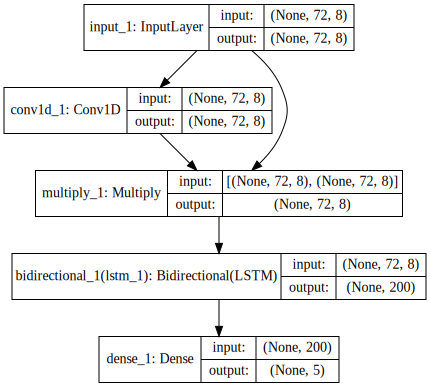

In [4]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [5]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('LSTM-ATTENTION-CONV1D-AF-BIDIRECT-energie.h5', monitor='val_acc', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[reduce_lr,best_checkpoint])

Train on 2301 samples, validate on 575 samples
Epoch 1/100
2301/2301 [==============================] - 21s 9ms/step - loss: 1.5974 - acc: 0.2486 - val_loss: 1.5391 - val_acc: 0.2383

Epoch 00001: val_acc improved from -inf to 0.23826, saving model to LSTM-ATTENTION-CONV1D-AF-BIDIRECT-energie.h5
Epoch 2/100
2301/2301 [==============================] - 9s 4ms/step - loss: 1.5302 - acc: 0.3242 - val_loss: 1.5097 - val_acc: 0.2470

Epoch 00002: val_acc improved from 0.23826 to 0.24696, saving model to LSTM-ATTENTION-CONV1D-AF-BIDIRECT-energie.h5
Epoch 3/100
2301/2301 [==============================] - 9s 4ms/step - loss: 1.4687 - acc: 0.3390 - val_loss: 1.4849 - val_acc: 0.2574

Epoch 00003: val_acc improved from 0.24696 to 0.25739, saving model to LSTM-ATTENTION-CONV1D-AF-BIDIRECT-energie.h5
Epoch 4/100
2301/2301 [==============================] - 9s 4ms/step - loss: 1.4383 - acc: 0.3542 - val_loss: 1.4869 - val_acc: 0.2383

Epoch 00004: val_acc did not improve from 0.25739
Epoch 5/100
2


Epoch 00080: val_acc did not improve from 0.39826
Epoch 81/100
2301/2301 [==============================] - 9s 4ms/step - loss: 1.3617 - acc: 0.3977 - val_loss: 1.3818 - val_acc: 0.3930

Epoch 00081: val_acc did not improve from 0.39826
Epoch 82/100
2301/2301 [==============================] - 9s 4ms/step - loss: 1.3669 - acc: 0.3977 - val_loss: 1.3813 - val_acc: 0.3826

Epoch 00082: val_acc did not improve from 0.39826
Epoch 83/100
2301/2301 [==============================] - 9s 4ms/step - loss: 1.3610 - acc: 0.4029 - val_loss: 1.3795 - val_acc: 0.3896

Epoch 00083: val_acc did not improve from 0.39826
Epoch 84/100
2301/2301 [==============================] - 9s 4ms/step - loss: 1.3638 - acc: 0.4050 - val_loss: 1.3795 - val_acc: 0.3948

Epoch 00084: val_acc did not improve from 0.39826
Epoch 85/100
2301/2301 [==============================] - 9s 4ms/step - loss: 1.3499 - acc: 0.3881 - val_loss: 1.3779 - val_acc: 0.3826

Epoch 00085: val_acc did not improve from 0.39826
Epoch 86/100
2

In [1]:
import json,codecs
import numpy as np
def saveHist(path,history):

    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n


saveHist('LSTM-ATTENTION-CONV1D-AF-BIDIRECT-energie.hist',history)
hist=loadHist('LSTM-ATTENTION-CONV1D-AF-BIDIRECT-energie.hist')




NameError: name 'history' is not defined

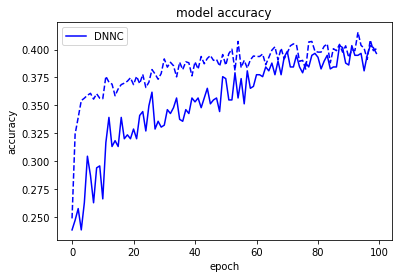

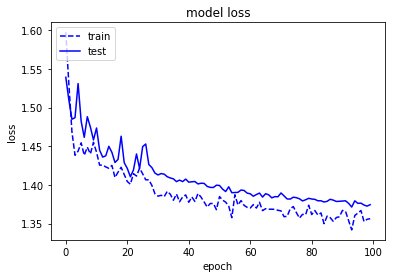

In [7]:
import matplotlib.pylab as plt

acc=np.array(hist['acc'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_acc'],'b',label='DNNC')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()